### Analysis of PIFiA Logistic Regression Models

The below code compares the predicted localization distributions per protein for the original-crops and masked-crops logistic regression models. It computes the KL Divergence between the predicted localization distributions for each protein and prints out the summary statistics.

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# --- Logistic Regression Model ---
class LogisticRegressionTorch(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionTorch, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# --- Load data ---
def load_data(csv_path):
    df = pd.read_csv(csv_path)
    df = df.drop_duplicates(subset=["yORF"]).reset_index(drop=True)
    feature_cols = [f"f{i}" for i in range(64)]
    X = torch.tensor(df[feature_cols].values, dtype=torch.float32)
    yorf = df["yORF"]
    return X, yorf

# --- Load model ---
def load_model(model_path, input_dim, num_classes):
    model = LogisticRegressionTorch(input_dim, num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# --- Compute KL divergence between two distributions ---
def kl_divergence(p, q):
    p = np.clip(p, 1e-10, 1)
    q = np.clip(q, 1e-10, 1)
    return np.sum(p * np.log(p / q))

# --- Main KL divergence comparison from scratch ---
def compute_kl_from_models(model1, model2, X1, X2, yorf1, yorf2):
    with torch.no_grad():
        probs1 = F.softmax(model1(X1), dim=1).numpy()
        probs2 = F.softmax(model2(X2), dim=1).numpy()

    df1 = pd.DataFrame(probs1)
    df1["yORF"] = yorf1.values

    df2 = pd.DataFrame(probs2)
    df2["yORF"] = yorf2.values

    df1 = df1.drop_duplicates(subset="yORF").set_index("yORF")
    df2 = df2.drop_duplicates(subset="yORF").set_index("yORF")

    common_yorfs = df1.index.intersection(df2.index)
    df1 = df1.loc[common_yorfs]
    df2 = df2.loc[common_yorfs]

    results = []
    for y in common_yorfs:
        p = df1.loc[y].values
        q = df2.loc[y].values
        kl = kl_divergence(p / np.sum(p), q / np.sum(q))
        results.append({"yORF": y, "kl_divergence": kl})

    return pd.DataFrame(results)

# --- Main ---
print("Loading data and models...")
X1, yorf1 = load_data("pifia_feature_sets/original_crops_test.csv")
X2, yorf2 = load_data("pifia_feature_sets/masked_crops_test.csv")

model1 = load_model("trained_models/original_crops_model.pth", X1.shape[1], 15)
model2 = load_model("trained_models/masked_crops_model.pth", X2.shape[1], 15)

print("Computing KL divergence between full distributions...")
kl_df = compute_kl_from_models(model1, model2, X1, X2, yorf1, yorf2)

# Can save KL Divergence results to a CSV file
# kl_df.to_csv("kl_divergence.csv", index=False)

print(kl_df["kl_divergence"].describe())


Loading data and models...
Computing KL divergence between full distributions...
count    1531.000000
mean        0.800180
std         0.947482
min         0.003260
25%         0.187370
50%         0.479301
75%         1.047329
max         9.751676
Name: kl_divergence, dtype: float64


The next code generates Figure 3A in the paper (a plot showing the distribution of KL Divergences).

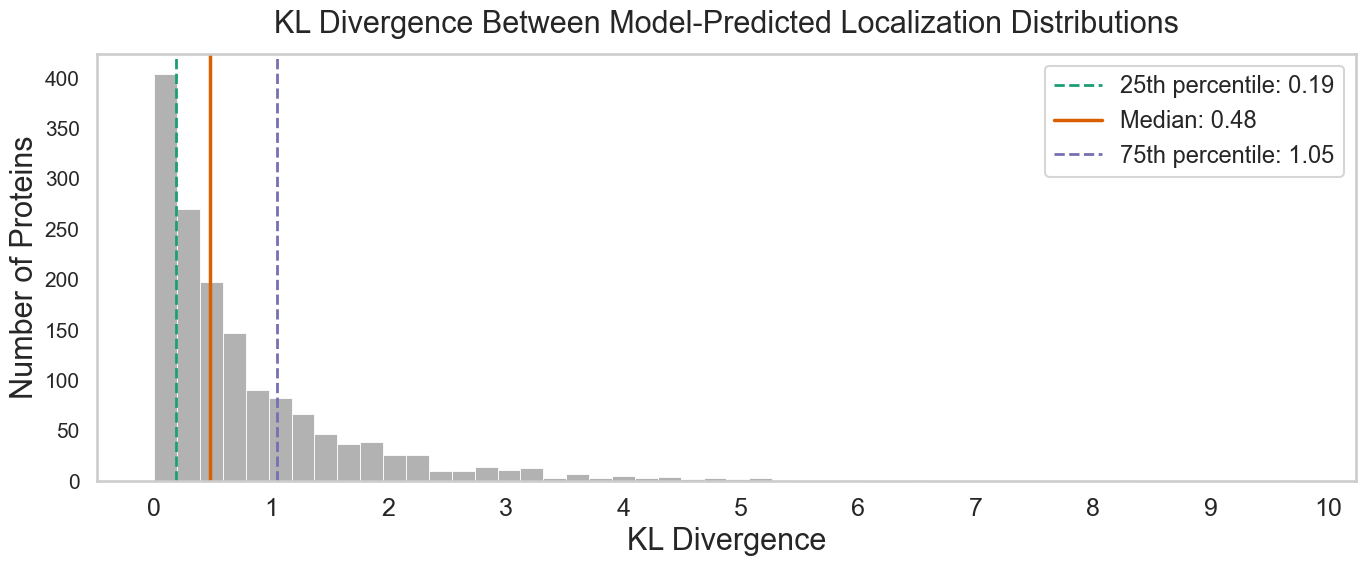

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Compute percentiles
q25 = np.percentile(kl_df["kl_divergence"], 25)
q50 = np.percentile(kl_df["kl_divergence"], 50)
q75 = np.percentile(kl_df["kl_divergence"], 75)

# Set font and style
sns.set(style="whitegrid", context="talk", palette="deep")

# Initialize the plot
plt.figure(figsize=(14, 6))

# Plot histogram
sns.histplot(kl_df["kl_divergence"], bins=50, color="#999999", edgecolor="white", linewidth=0.6)

# Plot percentile lines
plt.axvline(q25, color="#1b9e77", linestyle="--", linewidth=2, label=f"25th percentile: {q25:.2f}")
plt.axvline(q50, color="#d95f02", linestyle="-", linewidth=2.5, label=f"Median: {q50:.2f}")
plt.axvline(q75, color="#7570b3", linestyle="--", linewidth=2, label=f"75th percentile: {q75:.2f}")

# Customize axes and labels
plt.xticks(np.arange(0, 11, 1), fontsize=18)
plt.yticks(fontsize=15)
plt.xlabel("KL Divergence", fontsize=22)
plt.ylabel("Number of Proteins", fontsize=22)
plt.title("KL Divergence Between Model-Predicted Localization Distributions", fontsize=22, pad=15)

# Legend
plt.legend(frameon=True, fontsize=17, loc="upper right")

# Layout
plt.tight_layout()
plt.grid(False)
plt.show()
